# Breaking CAPTCHAs with Deep Learning: A fast.ai Approach

Ever wonder how those distorted text challenges called CAPTCHAs work—and how we might teach computers to solve them? Today we're diving into a practical machine learning project that combines computer vision and sequence recognition to crack this fascinating problem.

## The Big Picture: Why CAPTCHAs Matter

Before we get into the code, let's understand what we're really doing here. CAPTCHA recognition isn't just about bypassing security measures (which you shouldn't do without permission!). It's about solving a fundamental AI challenge: teaching machines to perceive and interpret visual sequences much like humans do.

This project demonstrates a powerful pattern in machine learning: **breaking complex problems into specialized sub-tasks**. Rather than building one massive model to handle everything, we'll use specialized components that excel at different aspects of the problem.

## What will we learn today

- Image processing: Handling and transforming image data.


- Deep learning architectures: Combining Convolutional Neural Networks (CNNs) for feature extraction and Recurrent Neural Networks (RNNs) for sequence processing.

- Specialized loss functions: Like Connectionist Temporal Classification (CTC) loss, which is essential for sequence-to-sequence tasks where alignment is unknown.


This notebook focuses on building such a model for educational purposes, demonstrating a powerful approach to sequence recognition in images.

## The Architecture: CNN + LSTM + CTC

Our solution uses three key elements:

1. **Convolutional Neural Networks (CNNs)** to process the image
2. **Long Short-Term Memory networks (LSTMs)** to interpret the sequence
3. **Connectionist Temporal Classification (CTC)** to handle alignment uncertainty

Let's see how these pieces work together using fast.ai and PyTorch.

## Objective of this notebook

1. Generate a synthetic dataset of CAPTCHA images and their corresponding text labels.
2. Preprocess the data into a format suitable for training a deep learning model using fastai.
3. Define and implement a CRNN model architecture tailored for CAPTCHA recognition.
4. Utilize CTC loss for training the model, which handles variable-length predictions.
5. Train the model using fastai's Learner and best practices like learning rate finding and one-cycle policy.
6. Visualize and evaluate the model's performance.

In [2]:
from fastai.vision.all import *
from fastai.text.all import *
from datasets import Dataset
from captcha.image import ImageCaptcha
import random
import string

In [101]:
import string
from fastai.vision.all import *
from fastai.text.all import *
from captcha.image import ImageCaptcha

# 1. Create vocabulary from all possible characters (since we know possible chars)
chars = sorted(string.ascii_uppercase + string.digits)


# Dataset

In [102]:
# 2. Create a fake CAPTCHA dataset
def create_captcha_dataset(size=100):
    generator = ImageCaptcha(width=160, height=60)
    data = []
    for _ in range(size):
        label = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
        img = generator.generate_image(label)
        data.append({'image': img, 'label': label})  # Using our custom class
    return Dataset.from_list(data)


def text_addition_rule(t, add_bos=True, add_eos=True):
    return (f'{BOS} ' if add_bos else '') + t + (f' {EOS}' if add_eos else '')

class CharTokenizerTransform(Transform):
    def __init__(self, special_tokens=None, sep='', rules=text_addition_rule):
        self.special_tokens = special_tokens or defaults.text_spec_tok
        self.sep = sep
        self.rules = L(ifnone(rules, defaults.text_proc_rules))

    def _tokenize1(self, o: str):
        # Apply preprocessing rules
        txt = compose(*self.rules)(o)
        tokens = []
        for word in txt.split(' '):
            if word in self.special_tokens:
                tokens.append(word)
            else:
                tokens.extend(list(word))
        return tokens

    def encodes(self, o: str):
        return self._tokenize1(o)

    def decodes(self, o):
        # Remove special tokens during decoding for display
        clean = [t for t in o if t not in self.special_tokens]
        return TitledStr(self.sep.join(clean))


In [106]:
vocab = make_vocab(Counter(chars), min_freq=1)

The `create_captcha_dataset` function generates our synthetic CAPTCHA dataset.
It initializes `ImageCaptcha` with a specified width and height for the images.
It then loops `size` times:


A random 5-character label is generated using uppercase letters and digits.
An image is generated for this label.
The image and its label are stored as a dictionary.


Finally, it converts this list of dictionaries into a datasets.Dataset object, which is a convenient format for handling data.

In [107]:
captcha_block = DataBlock(
    blocks=(ImageBlock, TextBlock(
        tok_tfm=CharTokenizerTransform,
        vocab=vocab
        
    )),
    get_x=lambda o: o['image'],
    get_y=lambda o: o['label'],
    splitter=RandomSplitter(0.2),
    item_tfms=None,
    batch_tfms=Normalize.from_stats(*imagenet_stats)
)

In [108]:

# 3. Generate the dataset
ds = create_captcha_dataset(1000)

dls = captcha_block.dataloaders(ds, bs=16)

In [109]:
x, y = dls.one_batch()

In [110]:
y

TensorText([[ 2, 15, 34, 18, 44, 39,  3],
            [ 2, 25, 23, 32, 13, 10,  3],
            [ 2, 41, 40, 37, 25, 30,  3],
            [ 2, 30, 14, 30, 30, 12,  3],
            [ 2, 36, 37, 38,  9, 19,  3],
            [ 2, 39, 35, 42, 22, 43,  3],
            [ 2, 17, 22, 16, 36, 37,  3],
            [ 2, 33, 25, 22, 32, 26,  3],
            [ 2, 30, 25, 34, 10, 15,  3],
            [ 2, 14, 37, 39, 26, 19,  3],
            [ 2, 22, 23, 24, 12, 11,  3],
            [ 2, 33, 21, 35, 16, 38,  3],
            [ 2, 29, 42, 35, 30, 32,  3],
            [ 2, 36, 29, 15, 21, 15,  3],
            [ 2, 25, 22, 27, 36, 18,  3],
            [ 2, 37, 23, 35, 31, 13,  3]], device='cuda:0')

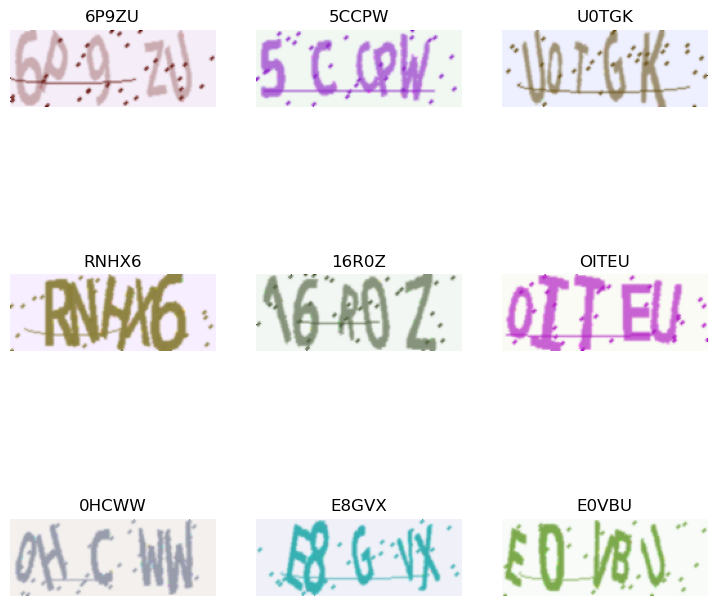

In [111]:
dls.show_batch()

<Axes: title={'center': '8BI1O'}>

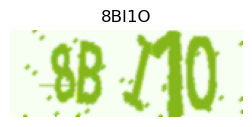

In [112]:
show_image(ds[0]['image'],title=ds[0]['label'],figsize=(3,5))

This line displays the first image from our dataset along with its label, allowing us to visually inspect what our generated CAPTCHAs look like.

In [228]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(1))  # Shape: [max_len, 1, d_model]

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
class CNNEncoder(nn.Module):
    def __init__(self, d_model=128):
        super().__init__()
        self.backbone = create_body(resnet18(), pretrained=True, cut=-2)
        self.conv = nn.Conv2d(512, d_model, 1)

    def forward(self, x):
        x = self.backbone(x)  # B x 512 x H x W
        x = self.conv(x)      # B x d_model x H x W
        B, C, H, W = x.shape
        return x.view(B, C, -1).permute(2, 0, 1)  # [Seq, B, d_model]
        
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

    def forward(self, tgt, memory):
        tgt_emb = self.embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.pos_encoder(tgt_emb)
        output = self.decoder(tgt_emb, memory)
        return self.fc(output)
    
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, max_seq_len=20, sos_idx=2, eos_idx=3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.max_seq_len = max_seq_len
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx

    def forward(self, x, y=None):
        memory = self.encoder(x)  # [seq_len, B, d_model]

        # Teacher-forcing mode
        if y is not None:
            tgt = y[:, :-1].permute(1, 0)  # [T, B]
            pred = self.decoder(tgt, memory)
            return pred

        # Auto-regressive inference
        bs = x.size(0)
        tgt = torch.full((1, bs), self.sos_idx, dtype=torch.long, device=x.device)
        outputs = []

        for _ in range(self.max_seq_len - 1):
            logits = self.decoder(tgt, memory)  # [T, B, vocab]
            next_token = logits[-1].argmax(dim=-1).unsqueeze(0)  # [1, B]
            tgt = torch.cat([tgt, next_token], dim=0)
            outputs.append(next_token)

            if (next_token == self.eos_idx).all():
                break

        return tgt.permute(1, 0)  # [B, T]

Notice how we're gradually reducing the height while preserving the width—this transforms the 2D image into a 1D sequence of features, perfect for our LSTM to process.

## Step 5: Training with fast.ai

In [352]:
from torch.nn.utils.rnn import pad_sequence

class SeqLoss(BaseLoss):
    def __init__(self, pad_idx, vocab, axis=-1):
        self.pad_idx = pad_idx
        self.vocab = vocab
        self.special_tokens = {'xxpad', 'xxbos', 'xxeos'}
        self.axis = axis
        super().__init__(nn.CrossEntropyLoss, axis=axis, ignore_index=pad_idx, reduction='mean')

    def __call__(self, output, target, **kwargs):
        # output: [T, B, vocab], target: [B, T]

        target = target[:, 1:]      # Skip <bos>
        return self.func(output.reshape(-1, output.shape[-1]), target.T.reshape(-1))

    def decodes(self, output):
        # output: [T, B, vocab]
        pred_tokens = output.argmax(dim=self.axis).permute(1, 0)  # [B, T]
        decoded = []
        for tokens in pred_tokens:
            data = [i.item() for i in tokens if self.vocab[i] not in self.special_tokens]
            decoded.append(torch.IntTensor(data))

        padded_tensor = pad_sequence(decoded, batch_first=True, padding_value=pad_idx)
        return TensorText(padded_tensor)
        
    def activation(self, output):
        return F.softmax(output, dim=self.axis)

In [353]:
from fastai.callback.core import Callback

class AddTargetToInput(Callback):
    def before_batch(self):
        # Combine input and target into a tuple
        self.learn.xb = (self.learn.xb[0], self.learn.yb[0])

In [354]:
pad_idx = vocab.index('xxpad')
bos_idx = vocab.index('xxbos')
eos_idx = vocab.index('xxeos')

In [383]:
vocab_size = len(vocab)
encoder = CNNEncoder(d_model=128)
decoder = TransformerDecoder(vocab_size, d_model=128)
model = EncoderDecoder(encoder, decoder, max_seq_len = 7, sos_idx = bos_idx, eos_idx=  eos_idx)
loss_func = SeqLoss(pad_idx=pad_idx, vocab=vocab)

In [388]:
from Levenshtein import distance as levenshtein_distance

from fastai.metrics import AccumMetric

from fastai.learner import Metric
from Levenshtein import distance as levenshtein_distance

def cer(preds, targets):
    """
    Compute the Character Error Rate (CER) between two lists of strings.
    """
    total_edits = 0
    total_chars = 0
    for pred, target in zip(preds, targets):
        total_edits += levenshtein_distance(pred, target)
        total_chars += len(target)
    return total_edits / total_chars if total_chars > 0 else 0



class CERMetric(Metric):
    def __init__(self, vocab):
        self.vocab = vocab

    def reset(self):
        self.total_edits = 0
        self.total_chars = 0

    def accumulate(self, learn):
        preds = learn.pred.argmax(dim=-1).permute(1, 0)  # [B, T]
        targs = learn.yb[0]  # [B, T]

        for pred_seq, targ_seq in zip(preds, targs):
            pred_str = ''.join([self.vocab[i] for i in pred_seq if self.vocab[i] not in ['xxpad', 'xxbos', 'xxeos']])
            targ_str = ''.join([self.vocab[i] for i in targ_seq if self.vocab[i] not in ['xxpad', 'xxbos', 'xxeos']])
            self.total_edits += levenshtein_distance(pred_str, targ_str)
            self.total_chars += len(targ_str)

    @property
    def value(self):
        return self.total_edits / self.total_chars if self.total_chars > 0 else None

    @property
    def name(self):
        return "CER"

    

In [389]:
learn = Learner(
        dls,
        model,
        loss_func=loss_func,
        cbs=[AddTargetToInput()],
        metrics=[CERMetric(vocab)],
        wd=1e-3  # Reduced weight decay
)

SuggestedLRs(valley=0.0003981071640737355)

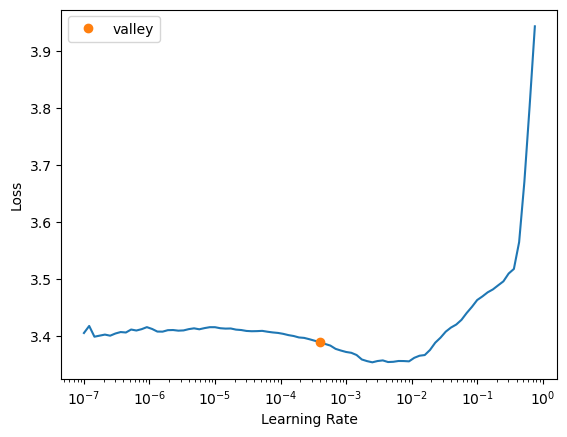

In [390]:
learn.lr_find()

In [392]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,CER,time
0,0.742924,1.931154,0.649000,00:03
1,0.941830,2.142130,0.657000,00:03
2,1.143967,1.997260,0.633000,00:03
3,1.107200,1.975749,0.629000,00:03
4,0.943000,1.854882,0.576000,00:03
5,0.721025,1.787975,0.552000,00:03
6,0.545432,1.826921,0.545000,00:03
7,0.388065,1.712268,0.530000,00:03
8,0.286351,1.692032,0.504000,00:03
9,0.235234,1.692899,0.500000,00:03


In [393]:
from plum import dispatch
class CaptchaStr(str):
    def show(self, ctx=None, **kwargs):
        return show_title(self, ctx=ctx)


@dispatch
def show_results(x:TensorImage, y:TensorText, samples, outs, ctxs=None, max_n=6, **kwargs):
    
    # ctxs = get_grid(min(len(samples), max_n)) if not ctxs else ctxs
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n))

    for i, ((img, tgt), pred) in enumerate(zip(samples, outs)):
        ctx = ctxs[i]
        img.show(ctx=ctx)

        # Decode target and prediction from TensorText
        tgt_str = CaptchaStr(tgt)
        pred_str = CaptchaStr(pred[0])
        
        ctx.set_title(f"Actual: {tgt_str}\nPred: {pred_str}", fontsize=8)
    
    return ctxs

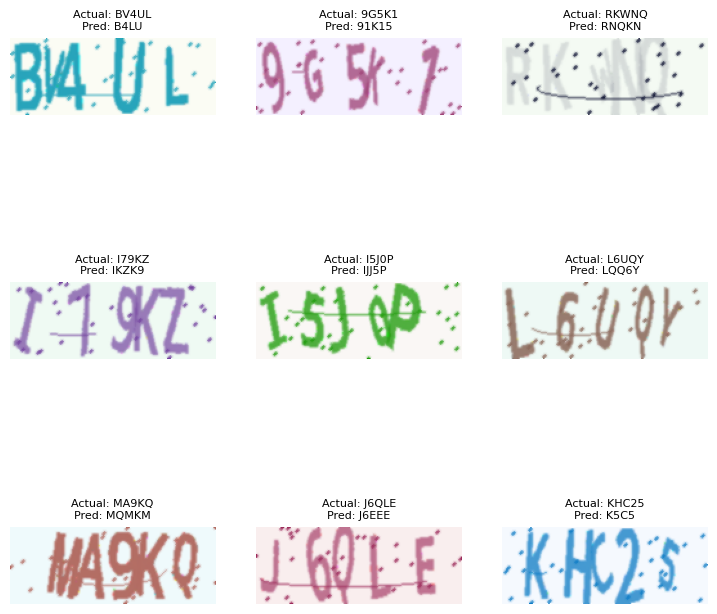

In [394]:

learn.show_results()

The model correctly identifies most CAPTCHAs, even with significant distortion and overlapping characters!

## The Machine Learning Mindset

What makes this approach successful isn't just the specific code, but the problem-solving pattern:

1. **Divide and conquer**: Separate image recognition from sequence interpretation
2. **Choose specialized tools**: CNNs for visual features, LSTMs for sequences
3. **Handle uncertainty**: Use CTC loss to manage the alignment problem
4. **Smart initialization**: Bias the model against blank predictions to avoid "blank collapse"
5. **Fine-tune learning rates**: Use different rates for different components

This same pattern can help solve many complex machine learning challenges:

- OCR for documents
- Speech recognition
- Video action recognition
- Medical time series analysis

## Going Further

Want to improve this model? Consider:

- Data augmentation (rotation, noise, blur) for more robust training
- Trying transformer architectures instead of LSTM
- Exploring beam search during decoding
- Testing on real-world CAPTCHAs (ethically, of course!)

Remember, the most valuable skill in machine learning isn't memorizing architectures—it's knowing how to decompose problems and connect specialized components in ways that leverage their strengths.

What machine learning challenge are you working on? Let me know in the comments!

- Processing medical imaging data with annotations

## Thinking Like a Machine Learning Engineer

The next time you face a complex ML problem, remember this approach:

1. What are the sub-problems?
2. What type of neural network is best for each part?
3. How do these parts need to talk to each other?
4. What's the right way to measure success?

By breaking down big problems into manageable pieces, even the most intimidating challenges become approachable.

So next time a CAPTCHA asks you to "prove you're human," you can smile knowing that the line between human and machine intelligence continues to blur—one squiggly character at a time.

*What machine learning challenge are you tackling? Share in the comments below!*